# MODNet 'matbench_dielectric' benchmarking

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



## Data exploration

In [2]:
df = load_dataset("matbench_dielectric")
# df["composition"] = df["composition"].map(Composition)

Fetching matbench_dielectric.json.gz from https://ml.materialsproject.org/projects/matbench_dielectric.json.gz to /Users/ppdebreuck/anaconda3/envs/modnet-develop/lib/python3.8/site-packages/matminer/datasets/matbench_dielectric.json.gz


In [3]:
from matminer.datasets import get_all_dataset_info

# Get dataset info from matminer
info = get_all_dataset_info("matbench_dielectric")

# Check out the info about the dataset.
print(info)

Dataset: matbench_dielectric
Description: Matbench v0.1 test dataset for predicting refractive index from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having refractive indices less than 1 and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	n: Target variable. Refractive index (unitless).
	structure: Pymatgen Structure of the material.
Num Entries: 4764
Reference: Petousis, I., Mrdjenovich, D., Ballouz, E., Liu, M., Winston, D.,
Chen, W., Graf, T., Schladt, T. D., Persson, K. A. & Prinz, F. B.
High-throughput screening of inorganic compounds for the discovery
of novel dielectric and optical materials. Sci. Data 4, 160134 (2017).
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexan

In [4]:
df.columns

Index(['structure', 'n'], dtype='object')

### Target space

In [5]:
df.describe()

,n
count,4764.000000
mean,2.428314
std,2.101722
min,1.000000
25%,1.684573
50%,2.060778
75%,2.595320
max,62.062998


Text(0.5, 0, 'n')

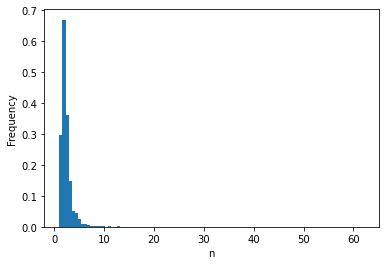

In [6]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["n"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("n")

In [ ]:
df['structure_dict'] = df['structure'].map(lambda x: x.as_dict())

In [ ]:
df = df.drop('structure',axis=1)

In [ ]:
df.to_csv('df.csv')

In [ ]:
df

## Featurization and feature selection

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
PRECOMPUTED_MODDATA = "./precomputed/dielectric_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_dielectric")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["n"].tolist(), 
        target_names=["n"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)
    # data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7fd9f19c6d60> object, created with modnet version 0.1.8~develop


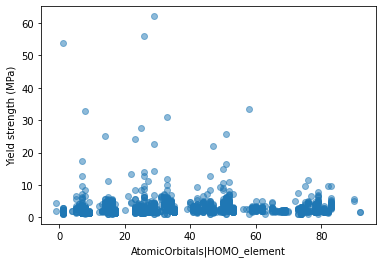

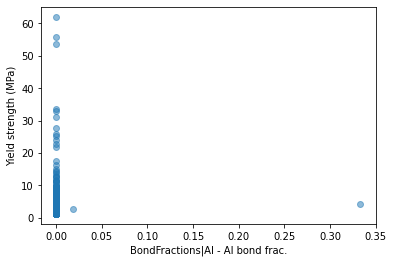

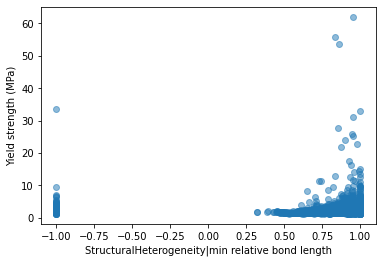

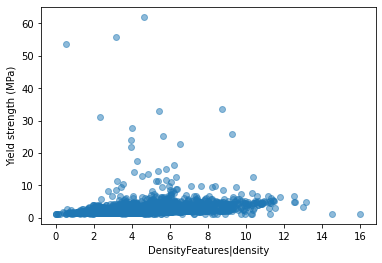

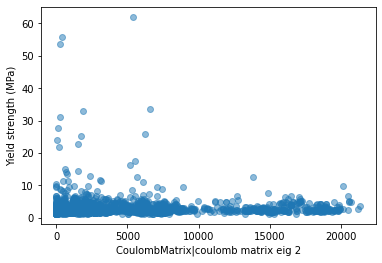

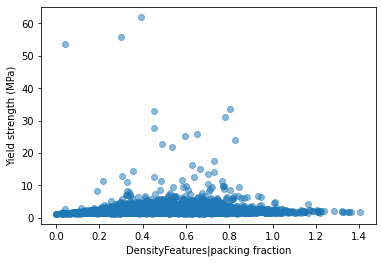

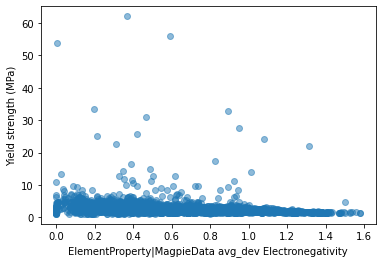

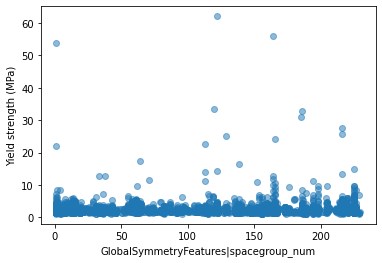

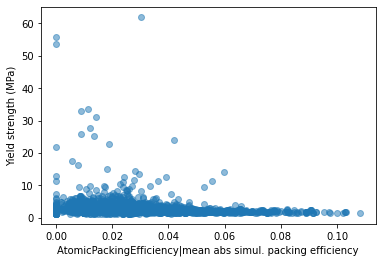

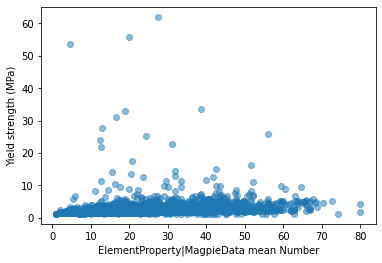

In [6]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Yield strength (MPa)")

## Training

In [7]:
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
try:
    matbench_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import matbench_benchmark


best_settings = {
    "increase_bs":False,
    "num_neurons": [[128], [32], [8], [8]],
    "n_feat": 512,
    "lr": 0.005,
    "epochs": 1000,
    "verbose": 0,
    "act": "relu",
    "batch_size": 64,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["n"]]], {"n": 1}, best_settings, save_folds=True)
np.mean(results['scores'])

INFO:root:Loading cross NMI from 'Features_cross' file.
INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...
INFO:root:Computing optimal features...
INFO:root:Selected 50/1095 features...
INFO:root:Selected 100/1095 features...
INFO:root:Selected 150/1095 features...
INFO:root:Selected 200/1095 features...
INFO:root:Selected 250/1095 features...
INFO:root:Selected 300/1095 features...
INFO:root:Selected 350/1095 features...
INFO:root:Selected 400/1095 features...
INFO:root:Selected 450/1095 features...
INFO:root:Selected 500/1095 features...
INFO:root:Selected 550/1095 features...
INFO:root:Selected 600/1095 features...
INFO:root:Selected 650/1095 features...
INFO:root:Selected 700/1095 features...
INFO:root:Selected 750/1095 features...
INFO:root:Selected 800/1095 features...
INFO:root:Selected 850/1095 features...
INFO:root:Selected 900/1095 features...
INFO:root:Selected 950/1095 features...
INFO:root:Selected 1000/1095 features.

KeyboardInterrupt: 

In [ ]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][50:])